## To be used on custom HEP dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, time, datetime
import logging, pickle

from scipy import stats
from pprint import pprint
from importlib import reload
from collections import defaultdict
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import roc_curve, roc_auc_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from models import losses, network, vae
from utils import helpers, datasets, math, distributions

import sklearn.datasets

In [2]:
from matplotlib import rc
rc('text', usetex=False) 

plt.style.use('seaborn-talk')

In [3]:
class args(object):
    silent = True
    n_epochs = 42
    batch_size = 4096
    latent_dim = 10
    learning_rate = 8e-4
    multigpu = True
    LOSSES = ['VAE', 'beta_VAE', 'annealed_VAE', 'factor_VAE', 'beta_TCVAE', 'beta_TCVAE_sensitive']
    DATASETS = ['mnist', 'dsprites', 'dsprites_scream', 'custom']
    save_interval = 32

    
    loss_type = 'beta_TCVAE'  # 'factor_VAE'
    dataset = 'custom'
    sampling_bias = False
    shuffle = True
    distribution = 'bernoulli'
    identifier = loss_type
    
    
    # Annealed VAE params
    beta = 4.0
    C_init = 0
    C_fin = 5
    gamma = 30.
    
    # Factor VAE params
    n_layers_D = 5
    n_units_D = 512
    lr_D = 5e-5
    gamma_fvae = 4.
    
    # BTC VAE params
    alpha_btcvae = 1.
    beta_btcvae = 12.
    gamma_btcvae = 1.
    supervision_lagrange_m = 64
    
    # Sensitive isolation
    supervision = True
    sensitive_latent_idx = [1]
    
    # Normalizing flow params
    use_flow = False
    flow_steps = 4
    
    # Misc.
    weight_decay = 1.0
    prior = 'normal'
    x_dist = 'normal'
    latent_spec = {'continuous': 10}
    mlp = False
    custom = True
    hidden_dim = 512
    
class directories(object):
    checkpoints = 'checkpoints'
    results = 'results'

if args.loss_type == 'factor_VAE':
    # Double batch size
    args.batch_size *= 2
    args.n_epochs *= 2
    
logger = helpers.logger_setup()

if args.supervision is True:
    args.identifier += '_supervised'
    
if args.sampling_bias is True:
    args.identifier += '_biased'
    args.shuffle = False
    
if args.use_flow is True:
    args.identifier += '_norm_flow'
    
args.name = '{}_{}_{}'.format(args.dataset, args.loss_type, args.identifier)

In [4]:
assert args.loss_type in args.LOSSES, 'Unrecognized loss type!'
assert args.dataset in args.DATASETS, 'Unrecognized dataset!'
test_loader = datasets.get_dataloaders(args.dataset,
                               batch_size=args.batch_size,
                               logger=logger,
                               train=False,
                               sampling_bias=args.sampling_bias,
                               shuffle=args.shuffle)

all_loader = datasets.get_dataloaders(args.dataset,
                               batch_size=args.batch_size,
                               logger=logger,
                               metrics=True,
                               evaluate=True,
                               train=False,
                               sampling_bias=args.sampling_bias,
                               shuffle=args.shuffle)


if args.supervision is False:
    train_loader = all_loader
else:
    train_loader = datasets.get_dataloaders(args.dataset,
                                   batch_size=args.batch_size,
                                   logger=logger,
                                   train=True,
                                   sampling_bias=args.sampling_bias,
                                   shuffle=args.shuffle)



args.n_data = len(train_loader.dataset)

try:
    args.input_dim = datasets.get_img_size(args.dataset)
except AttributeError:
    pass

Data shape: (1522904, 36)
Features ['BB_gamma_hel', 'B_CosTBTO', 'B_CosTBz', 'B_R2', 'B_ThrustB', 'B_ThrustO', 'B_cms_cosTheta', 'B_cms_daughterSumOf_pt', 'B_gamma_cmsEnergyErr', 'B_gamma_cms_E', 'B_gamma_cms_clusterAbsZernikeMoment40', 'B_gamma_cms_clusterAbsZernikeMoment51', 'B_gamma_cms_clusterE1E9', 'B_gamma_cms_clusterE9E21', 'B_gamma_cms_clusterErrorE', 'B_gamma_cms_clusterHighestE', 'B_gamma_cms_clusterLAT', 'B_gamma_cms_clusterPhi', 'B_gamma_cms_clusterTheta', 'B_gamma_cms_clusterUncorrE', 'B_gamma_cms_cosTheta', 'B_gamma_cms_eRecoil', 'B_gamma_cms_m2Recoil', 'B_gamma_cms_pRecoil', 'B_gamma_cms_phi', 'B_gamma_cms_pt', 'B_useCMSFrame_bodaughterHighest_boE', 'B_useCMSFrame_bodaughterHighest_bop', 'B_useCMSFrame_bodaughterHighest_bopt', 'B_useCMSFrame_bodaughterHighest_bopx', 'B_useCMSFrame_bodaughterHighest_bopy', 'B_useCMSFrame_bodaughterHighest_bopz', 'B_useCMSFrame_bodaughterSumOf_bopt', 'B_useCMSFrame_bodaughterSumOf_bopx', 'B_useCMSFrame_bodaughterSumOf_bopy', 'B_useCMSFrame

In [5]:
dataiter = iter(all_loader)
features, gen_factors = dataiter.next()
features = features[:8]
gen_factors = gen_factors[:8]

logger.info('Training: {} | Testing: {}'.format(len(train_loader.dataset), len(test_loader.dataset)))

if hasattr(args, 'input_dim') is False:
    args.input_dim = features.shape[-1]

04:28:24 INFO - <module>: Training: 3255206 | Testing: 1522904


In [6]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
    

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

In [7]:
class ARMLP(nn.Module):
    """ a 4-layer auto-regressive MLP, wrapper around MADE net """

    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.net = MADE(input_dim, [hidden_dim, hidden_dim, hidden_dim], output_dim, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

In [8]:
class MAF(nn.Module):
    """ Masked Autoregressive Flow that uses a MADE-style network for fast forward """
    
    def __init__(self, input_dim, parity, hidden_dim=64, net_class=ARMLP):
        super().__init__()
        self.dim = input_dim
        self.net = net_class(input_dim, input_dim*2, hidden_dim)
        self.parity = parity

    def forward(self, x):
        # here we see that we are evaluating all of z in parallel, so density estimation will be fast
        st = self.net(x)
        s, t = st.split(self.dim, dim=1)
        z = x * torch.exp(s) + t
        # reverse order, so if we stack MAFs correct things happen
        z = z.flip(dims=(1,)) if self.parity else z
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def invert(self, z):
        # we have to decode the x one at a time, sequentially
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0)).type_as(z.data)
        z = z.flip(dims=(1,)) if self.parity else z
        for i in range(self.dim):
            st = self.net(x.clone()) # clone to avoid in-place op errors if using IAF
            s, t = st.split(self.dim, dim=1)
            x[:, i] = (z[:, i] - t[:, i]) * torch.exp(-s[:, i])
            log_det += -s[:, i]
        return x, log_det

In [9]:
class NVP_net(nn.Module):
    """ Network for use for transforms in real-NVP """

    def __init__(self, input_dim, output_dim, hidden_dim=128, activation='leaky_relu', scale=False):
        super(NVP_net, self).__init__()

        self.input_dim = input_dim
        self.scale = scale
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        self.scale_act = nn.Tanh()
        self.tanh_scale = nn.Parameter(torch.ones(1), requires_grad=True)

        # self.act = nn.LeakyReLU(0.2, inplace=True)  # nn.ReLU(inplace=True)
        self.act = getattr(F, activation)

    def forward(self, x):

        h = x.view(-1, self.input_dim)
        h = self.act(self.fc1(h))
        h = self.act(self.fc2(h))

        h = self.act(self.fc3(h))

        out = self.out(h)
        
        if self.scale is True:
            out = self.tanh_scale * self.scale_act(out)
        
        return out

In [10]:
class BatchNormFlow(nn.Module):
    """ Implements forward and inverse batch
        norm passes, as well as log determinant of
        Jacobian of forward and inverse passes """
    
    def __init__(self, input_dim, momentum=0.05, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        
        self.log_gamma = nn.Parameter(torch.zeros(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(input_dim))
        self.register_buffer('running_var', torch.ones(input_dim))
        
        
    def forward(self, u):
        """
        Use recorded running mean/var to invert BN applied during
        inverse pass.
        """
        mu, var = self.running_mean, self.running_var
        
        x = (u - self.beta) * torch.exp(-self.log_gamma) * torch.sqrt(var + self.eps) + mu
        log_det_jacobian_inv = -torch.sum(self.log_gamma - 0.5 * torch.log(var + self.eps))

        return x, log_det_jacobian_inv
   
        
    def invert(self, x):
        """
        Apply BN using minibatch statistics, update running mean/var.
        """
        batch_mu = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0)
        
        self.running_mean.mul_(self.momentum)
        self.running_var.mul_(self.momentum)

        self.running_mean.add_(batch_mu.data * (1 - self.momentum))
        self.running_var.add_(batch_var.data * (1 - self.momentum))
        
        x = torch.exp(self.log_gamma) * (x - batch_mu) * 1. / torch.sqrt(batch_var + self.eps) + self.beta
        log_det_jacobian = torch.sum(self.log_gamma -0.5 * torch.log(batch_var + self.eps))
        
        return x, log_det_jacobian

In [11]:
class InvertibleAffineFlow(nn.Module):
    """ 
    Implements real-NVP affine autoregressive flow [1] as 
    location-scale transform. 

    Parition input z = [z1 | z2], then applies autoregressive
    transformation z' = f(z), wehre f:
    z1' = z1
    z2' = exp(s(z1)) * z2 + t(z1)

    [1] Density estimation using Real-NVP, Dinh et. al. 2016
        arXiv:1605.08803
    """

    def __init__(self, input_dim, parity=False, hidden_dim=256):
        super(InvertibleAffineFlow, self).__init__()

        self.input_dim = input_dim
        self.parity = parity
        self.hidden_dim = hidden_dim

        self.net = NVP_net

        self.s_psi = self.net(input_dim=self.input_dim//2, output_dim=self.input_dim//2, hidden_dim=self.hidden_dim, scale=True)
        self.t_psi = self.net(input_dim=self.input_dim//2, output_dim=self.input_dim//2, hidden_dim=self.hidden_dim)

        
    def forward(self, x):
        x0, x1 = x[:,::2], x[:,1::2]
        
        if self.parity is True:  # Exchange partitions on successive transformations
            x0, x1 = x1, x0

        s_x0, t_x0 = self.s_psi(x0), self.t_psi(x0)
        z0 = x0  # Identity
        z1 = torch.exp(s_x0) * x1 + t_x0  # location-scale transform

        if self.parity is True:
            z0, z1 = z1, z0

        z = torch.cat([z0, z1], dim=1)
        log_det_jacobian = torch.sum(s_x0, dim=1)
        
        return z, log_det_jacobian


    def invert(self, z):
        z0, z1 = z[:,::2], z[:,1::2]
        if self.parity is True:
            z0, z1 = z1, z0

        s_z0, t_z0 = self.s_psi(z0), self.t_psi(z0)
        x0 = z0  # Identity
        x1 = (z1 - t_z0) * torch.exp(-s_z0)  # Inverse location-scale transform

        if self.parity is True:
            x0, x1 = x1, x0

        x = torch.cat([x0, x1], dim=1)

        # |det J_{T^{-1}}(x)| = |det(J_T(u))|^{-1}
        log_det_jacobian = -torch.sum(s_z0, dim=1)

        return x, log_det_jacobian

In [ ]:
class FlowModel(nn.Module):
    """ Subclass of VAE - implements invertible normalizing flows in the decoder.
        Identical encoder logic to standard VAE. Allows density estimation of 
        data x = T(u) by computing p(T^{-1}(x)) + log |det J_{T^{-1}}(x)|}. 
        Composes arbitary flows. """

    def __init__(self, input_dim, hidden_dim, base_dist, n_flows=2, device='cpu',
                 flow=InvertibleAffineFlow):
        super(FlowModel, self).__init__()
        
        self.n_flows = n_flows
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.base_dist = base_dist
        
        BN_flow = BatchNormFlow
        parity = lambda n: True if n%2==0 else False
        
        # Aggregate parameters from each transformation in the flow
        for k in range(self.n_flows):
            flow_k = flow(input_dim=self.input_dim, parity=parity(k), hidden_dim=self.hidden_dim)
            BN_k = BN_flow(input_dim=self.input_dim)
            self.add_module('flow_{}'.format(str(k)), flow_k)
            self.add_module('BN_{}'.format(str(k)), BN_k)


    def forward(self, x_0):
        """ Sample from target density by passing x0 sampled from
            base distribution through forward flow, x = F(x_0). 
            Used for sampling from trained model. """

        batch_size = x_0.shape[0]
        x_flow = [x_0]  # Sequence of residual flows. \hat{x} = x_flow[-1]

        log_det_jacobian = torch.zeros(batch_size).to(device)

        for k in range(self.n_flows):
            
            x_k = x_flow[-1]
            flow_k = getattr(self, 'flow_{}'.format(str(k)))
            x_k, log_det_jacobian_k = flow_k.forward(x_k)
            
            # Don't apply batch norm after final forward flow T_{K-1}
            if k < self.n_flows - 1:
                BN_k = getattr(self, 'BN_{}'.format(str(k)))
                x_k, log_det_jacobian_BN_k = BN_k.forward(x_k)
                log_det_jacobian += log_det_jacobian_BN_k
                
            x_flow.append(x_k)
            
            log_det_jacobian += log_det_jacobian_k


        # Final approximation of target sample
        x_K = x_flow[-1]

        flow_output = {'log_det_jacobian': log_det_jacobian, 'x_flow': x_flow}

        return flow_output 


    def backward(self, x):
        """ Recover base x0 ~ N(\mu, \Sigma) by inverting 
            flow transformations. x0 = F^{-1}(x) Used for density 
            evaluation when computing likelihood term in VAE loss. """

        x_flow_inv = [x]
        batch_size = x.shape[0]
        log_det_jacobian_inv = torch.zeros(batch_size).to(device)

        # Sequence T^{-1}(x) = u ==> x -> x_{K-1} -> ... -> x_1 -> u
        for k in range(self.n_flows)[::-1]:  # reverse order
            
            x_k = x_flow_inv[-1]
            
            # Don't apply batch norm before transform T^{-1}_{K_1}
            if k < self.n_flows - 1:
                BN_k = getattr(self, 'BN_{}'.format(str(k)))
                x_k, log_det_jacobian_BN_k = BN_k.invert(x_k)
                log_det_jacobian_inv += log_det_jacobian_BN_k

            flow_k = getattr(self, 'flow_{}'.format(str(k)))
            x_k, log_det_jacobian_k = flow_k.invert(x_k)
        
            x_flow_inv.append(x_k)
            
            log_det_jacobian_inv += log_det_jacobian_k


        inv_flow_output = {'log_det_jacobian_inv': log_det_jacobian_inv, 'x_flow_inv': x_flow_inv}

        return inv_flow_output
    
    def log_density(self, x):
        
        inv_flow_output = self.backward(x)
        
        log_det_jacobian_inv = inv_flow_output['log_det_jacobian_inv']
        x_flow_inv = inv_flow_output['x_flow_inv']
        
        x_0 = x_flow_inv[-1]
        log_px_0 = self.base_dist.log_prob(x_0.cpu()).cuda()
        log_px = log_px_0 + log_det_jacobian_inv
        
        return log_px
    
    def sample(self, n_samples):
        
        x_0 = self.base_dist.sample(torch.Size([n_samples])).cuda()
        
        flow_output = self.forward(x_0)
        log_det_jacobian = flow_output['log_det_jacobian']
        x_flow = flow_output['x_flow']
        x_K = x_flow[-1]
        
        log_px_0 = self.base_dist.log_prob(x_0.cpu()).cuda()
        
        log_px_K = log_px_0 - log_det_jacobian
        
        return x_K, log_px_K

In [13]:
input_dim = 36
hidden_dim = 64

prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))

device = helpers.get_device()

myflow = FlowModel(input_dim=input_dim, hidden_dim=hidden_dim, base_dist=prior, n_flows=4, device=device)
myflow.to(device)
optimizer = torch.optim.Adam(myflow.parameters(), lr=1e-4 , weight_decay=1e-4)

In [14]:
z = torch.randn([128,36])

In [15]:
def train(model, data_loader, optimizer, device, logger, n_epochs=4):
    
    print('Using device', device)
    for epoch in trange(n_epochs, desc='Epoch'):
        for idx, (x, gen_factors) in enumerate(tqdm_notebook(data_loader, desc='Train'), 0):
            x = x.to(device)
            log_px = model.log_density(x).mean()
            
            loss = -log_px
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if idx % 100 == 0:
                logger.info('Epoch: {} | Iteration: {}  | log_px = {:.3f}'.format(epoch, idx, log_px))

In [16]:
train(myflow, train_loader, optimizer, device, logger, 10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Using device cuda


14:26:26 INFO - train: Epoch: 0 | Iteration: 0  | log_px = -14.750
14:27:38 INFO - train: Epoch: 0 | Iteration: 100  | log_px = -13.835
14:28:47 INFO - train: Epoch: 0 | Iteration: 200  | log_px = -11.094
14:29:57 INFO - train: Epoch: 0 | Iteration: 300  | log_px = -5.809
14:31:06 INFO - train: Epoch: 0 | Iteration: 400  | log_px = -0.813
14:32:16 INFO - train: Epoch: 0 | Iteration: 500  | log_px = 5.501
14:33:26 INFO - train: Epoch: 0 | Iteration: 600  | log_px = 13.620
14:34:37 INFO - train: Epoch: 0 | Iteration: 700  | log_px = 19.862
Epoch:  10%|█         | 1/10 [09:19<1:23:58, 559.84s/it]

14:35:45 INFO - train: Epoch: 1 | Iteration: 0  | log_px = 23.981
14:36:55 INFO - train: Epoch: 1 | Iteration: 100  | log_px = 27.514
14:38:05 INFO - train: Epoch: 1 | Iteration: 200  | log_px = 29.466
14:39:16 INFO - train: Epoch: 1 | Iteration: 300  | log_px = 32.594
14:40:25 INFO - train: Epoch: 1 | Iteration: 400  | log_px = 34.206
14:41:36 INFO - train: Epoch: 1 | Iteration: 500  | log_px = 34.940
14:42:44 INFO - train: Epoch: 1 | Iteration: 600  | log_px = 35.660
14:43:55 INFO - train: Epoch: 1 | Iteration: 700  | log_px = 37.554
Epoch:  20%|██        | 2/10 [18:35<1:14:22, 557.80s/it]

14:45:01 INFO - train: Epoch: 2 | Iteration: 0  | log_px = 38.406
14:46:12 INFO - train: Epoch: 2 | Iteration: 100  | log_px = 39.556
14:47:22 INFO - train: Epoch: 2 | Iteration: 200  | log_px = 40.466
14:48:31 INFO - train: Epoch: 2 | Iteration: 300  | log_px = 41.488
14:49:41 INFO - train: Epoch: 2 | Iteration: 400  | log_px = 42.172
14:50:52 INFO - train: Epoch: 2 | Iteration: 500  | log_px = 41.953
14:52:03 INFO - train: Epoch: 2 | Iteration: 600  | log_px = 42.385
14:53:14 INFO - train: Epoch: 2 | Iteration: 700  | log_px = 43.747
Epoch:  30%|███       | 3/10 [27:55<1:05:08, 558.39s/it]

14:54:20 INFO - train: Epoch: 3 | Iteration: 0  | log_px = 44.368
14:55:32 INFO - train: Epoch: 3 | Iteration: 100  | log_px = 45.111
14:56:42 INFO - train: Epoch: 3 | Iteration: 200  | log_px = 45.228
14:57:53 INFO - train: Epoch: 3 | Iteration: 300  | log_px = 46.253
14:59:03 INFO - train: Epoch: 3 | Iteration: 400  | log_px = 46.538
15:00:14 INFO - train: Epoch: 3 | Iteration: 500  | log_px = 45.746
15:01:21 INFO - train: Epoch: 3 | Iteration: 600  | log_px = 47.235
15:02:30 INFO - train: Epoch: 3 | Iteration: 700  | log_px = 48.186
Epoch:  40%|████      | 4/10 [37:11<55:47, 557.98s/it]  

15:03:37 INFO - train: Epoch: 4 | Iteration: 0  | log_px = 47.992
15:04:48 INFO - train: Epoch: 4 | Iteration: 100  | log_px = 48.127
15:05:58 INFO - train: Epoch: 4 | Iteration: 200  | log_px = 48.575
15:07:09 INFO - train: Epoch: 4 | Iteration: 300  | log_px = 48.527
15:08:19 INFO - train: Epoch: 4 | Iteration: 400  | log_px = 49.508
15:09:31 INFO - train: Epoch: 4 | Iteration: 500  | log_px = 49.110
15:10:40 INFO - train: Epoch: 4 | Iteration: 600  | log_px = 50.072
15:11:51 INFO - train: Epoch: 4 | Iteration: 700  | log_px = 50.772
Epoch:  50%|█████     | 5/10 [46:31<46:31, 558.37s/it]

15:12:57 INFO - train: Epoch: 5 | Iteration: 0  | log_px = 50.501
15:14:08 INFO - train: Epoch: 5 | Iteration: 100  | log_px = 50.462
15:15:19 INFO - train: Epoch: 5 | Iteration: 200  | log_px = 51.115
15:16:29 INFO - train: Epoch: 5 | Iteration: 300  | log_px = 49.759
15:17:39 INFO - train: Epoch: 5 | Iteration: 400  | log_px = 52.229
15:18:49 INFO - train: Epoch: 5 | Iteration: 500  | log_px = 51.745
15:20:00 INFO - train: Epoch: 5 | Iteration: 600  | log_px = 52.137
15:21:10 INFO - train: Epoch: 5 | Iteration: 700  | log_px = 51.606
Epoch:  60%|██████    | 6/10 [55:52<37:14, 558.69s/it]

15:22:17 INFO - train: Epoch: 6 | Iteration: 0  | log_px = 52.697
15:23:27 INFO - train: Epoch: 6 | Iteration: 100  | log_px = 52.267
15:24:37 INFO - train: Epoch: 6 | Iteration: 200  | log_px = 52.808
15:25:56 INFO - train: Epoch: 6 | Iteration: 300  | log_px = 52.996
15:27:36 INFO - train: Epoch: 6 | Iteration: 400  | log_px = 53.393
15:29:16 INFO - train: Epoch: 6 | Iteration: 500  | log_px = 51.589
15:30:54 INFO - train: Epoch: 6 | Iteration: 600  | log_px = 52.696
15:32:34 INFO - train: Epoch: 6 | Iteration: 700  | log_px = 51.775
Epoch:  70%|███████   | 7/10 [1:07:41<29:00, 580.24s/it]

15:34:07 INFO - train: Epoch: 7 | Iteration: 0  | log_px = 51.292
15:35:47 INFO - train: Epoch: 7 | Iteration: 100  | log_px = 52.816
15:37:26 INFO - train: Epoch: 7 | Iteration: 200  | log_px = 54.678
15:39:05 INFO - train: Epoch: 7 | Iteration: 300  | log_px = 53.926
15:40:44 INFO - train: Epoch: 7 | Iteration: 400  | log_px = 54.330
15:42:23 INFO - train: Epoch: 7 | Iteration: 500  | log_px = 54.701
15:43:57 INFO - train: Epoch: 7 | Iteration: 600  | log_px = 53.442
15:45:33 INFO - train: Epoch: 7 | Iteration: 700  | log_px = 55.573
Epoch:  80%|████████  | 8/10 [1:20:38<20:09, 604.79s/it]

15:47:04 INFO - train: Epoch: 8 | Iteration: 0  | log_px = 55.019
15:48:42 INFO - train: Epoch: 8 | Iteration: 100  | log_px = 55.225
15:50:21 INFO - train: Epoch: 8 | Iteration: 200  | log_px = 55.900
15:51:59 INFO - train: Epoch: 8 | Iteration: 300  | log_px = 55.491
15:53:36 INFO - train: Epoch: 8 | Iteration: 400  | log_px = 54.651
15:55:18 INFO - train: Epoch: 8 | Iteration: 500  | log_px = 55.617
15:56:58 INFO - train: Epoch: 8 | Iteration: 600  | log_px = 55.180
15:58:34 INFO - train: Epoch: 8 | Iteration: 700  | log_px = 55.346
Epoch:  90%|█████████ | 9/10 [1:33:40<10:24, 624.54s/it]

16:00:06 INFO - train: Epoch: 9 | Iteration: 0  | log_px = 55.920
16:01:46 INFO - train: Epoch: 9 | Iteration: 100  | log_px = 56.132
16:03:21 INFO - train: Epoch: 9 | Iteration: 200  | log_px = 56.076
16:04:58 INFO - train: Epoch: 9 | Iteration: 300  | log_px = 56.514
16:06:37 INFO - train: Epoch: 9 | Iteration: 400  | log_px = 56.142
16:08:12 INFO - train: Epoch: 9 | Iteration: 500  | log_px = 53.778
16:09:47 INFO - train: Epoch: 9 | Iteration: 600  | log_px = 56.935
16:11:25 INFO - train: Epoch: 9 | Iteration: 700  | log_px = 55.751
Epoch: 100%|██████████| 10/10 [1:46:30<00:00, 639.08s/it]

In [20]:
n_samples = 10000

dataiter = iter(train_loader)
features, gen_factors = dataiter.next()
features = features[:n_samples]
labels = gen_factors[0, :n_samples]

x_hat, log_px_hat = myflow.sample(n_samples)
x_hat = x_hat.cpu().detach()
log_px_hat = log_px_hat.cpu().detach()
x_dim = features.shape[1]

for dim in range(x_dim):
    real_marginal = features[:, dim]
    gen_marginal = x_hat[:, dim]

In [21]:
def compare_histograms_overlay(data_gen, data_real, nbins=50, norm=True, name='plot'):
    # Plot continuum suppression variable distributions for signal, background
    sea_green = '#54ff9f'
    steel_blue = '#4e6bbd'

    sns.distplot(data_gen, color=steel_blue, hist=True, kde=False, norm_hist=norm, label='Generated', bins=nbins,
         hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha=0.65))

    sns.distplot(data_real, color=sea_green, hist=True, kde=False, norm_hist=norm, label='Real', bins=nbins,
         hist_kws=dict(edgecolor="0.85", linewidth=0.5, alpha=0.8))
        
    plt.autoscale(enable=True, axis='x', tight=False)
    
    if norm:
        plt.ylabel(r'Normalized events/bin')
    else:
        plt.ylabel(r'Events/bin')

    plt.legend(loc="best")
    # plt.savefig('graphs/{}_{}.pdf'.format(name,variable), bbox_inches='tight',format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

ValueError: max must be larger than min in range parameter.

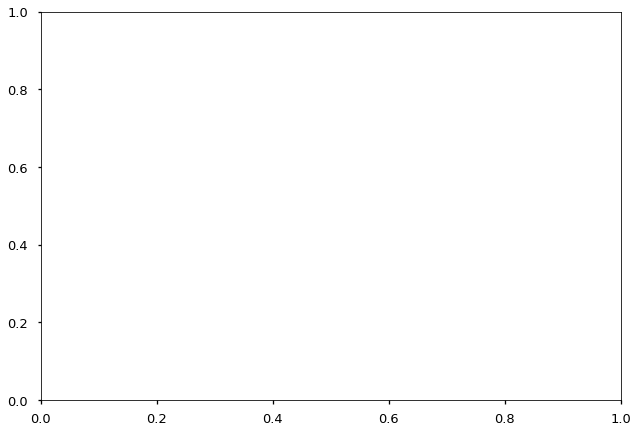

In [22]:
idx = 15
compare_histograms_overlay(x_hat[:,idx], features[:,idx])

# FFJORD

In [16]:
input_dim = 2
hidden_dim = 32

prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))

device = helpers.get_device()

myflow = FlowModel(input_dim=input_dim, hidden_dim=hidden_dim, base_dist=prior, n_flows=4, device=device)
myflow.to(device)
optimizer = torch.optim.Adam(myflow.parameters(), lr=1e-4 , weight_decay=1e-4)

In [ ]:
regularization_fns, regularization_coeffs = create_regularization_fns(args)
model = build_model_tabular(args, 2, regularization_fns).to(device)
if args.spectral_norm: add_spectral_norm(model)
set_cnf_options(args, model)

logger.info(model)
logger.info("Number of trainable parameters: {}".format(count_parameters(model)))

In [ ]:
def compute_loss(args, model, batch_size=None):
    if batch_size is None: batch_size = args.batch_size

    # load data
    # x = toy_data.inf_train_gen(args.data, batch_size=batch_size)
    x = sklearn.datasets.make_moons(n_samples=256, noise=.05)[0].astype(np.float32)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    z, delta_logp = model(x, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

Iteration:   0%|          | 0/8000 [00:00<?, ?it/s]

Using device cuda


04:30:14 INFO - train_moons: Iteration: 0  | log_px = -2.031
Iteration: 100%|██████████| 8000/8000 [04:03<00:00, 32.92it/s]


Text(0.5,1,'$x = T(u)$')

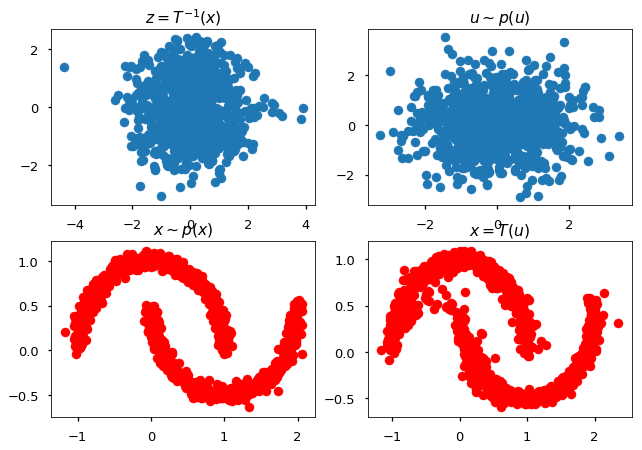

In [17]:
def train_moons(model, optimizer, device, logger, iterations=8000):
    
    print('Using device', device)
    for idx in trange(iterations, desc='Iteration'):
        noisy_moons = sklearn.datasets.make_moons(n_samples=256, noise=.05)[0].astype(np.float32)
        x = torch.from_numpy(noisy_moons).to(device)
        log_px = model.log_density(x).mean()

        loss = -log_px
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 500 == 0:
            logger.info('Iteration: {}  | log_px = {:.3f}'.format(idx, log_px))

train_moons(myflow, optimizer, device, logger)

noisy_moons = sklearn.datasets.make_moons(n_samples=1024, noise=.05)[0].astype(np.float32)
z = myflow.backward(torch.from_numpy(noisy_moons).to(device))['x_flow_inv'][-1].cpu().detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = T^{-1}(x)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1024)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$u \sim p(u)$')

plt.subplot(223)
x = sklearn.datasets.make_moons(n_samples=1024, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$x \sim p(x)$')

plt.subplot(224)
x = myflow.sample(1024)[0].cpu().detach().numpy()
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$x = T(u)$')